## Problem Statement 

With the advancement in technology, it is imperative for Ebuss to grow quickly in the e-commerce market to become a major leader in the market because it has to compete with the likes of Amazon, Flipkart, etc., which are already market leaders.

As a senior ML Engineer, you are asked to build a model that will improve the recommendations given to the users given their past reviews and ratings. 

In order to do this, you planned to build a sentiment-based product recommendation system

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#### Importing the packages

In [ ]:
import pandas as pd
import nltk
import re
import matplotlib.pyplot as plt
from nltk.stem import WordNetLemmatizer

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB

from xgboost import XGBClassifier
from sklearn.metrics.pairwise import pairwise_distances
import pickle
from nltk.corpus import stopwords
from datetime import datetime
import seaborn as sns
import numpy as np
from wordcloud import WordCloud, STOPWORDS

pd.set_option('display.max_colwidth', None)
pd.set_option('max_column', 100)

nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

##### Reading the data

In [103]:
data_ebuss = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/capstone/sample30.csv')
data_ebuss.head()

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative


##### Checking for any null values so as to perform data cleaning 

In [ ]:
data_ebuss.isnull().sum()

id                          0
brand                       0
categories                  0
manufacturer              141
name                        0
reviews_date               46
reviews_didPurchase     14068
reviews_doRecommend      2570
reviews_rating              0
reviews_text                0
reviews_title             190
reviews_userCity        28071
reviews_userProvince    29830
reviews_username           63
user_sentiment              1
dtype: int64

In [ ]:
data_ebuss['reviews_username'].head() # having a glimpse at the usernames

0       joshua
1    dorothy w
2    dorothy w
3      rebecca
4    walker557
Name: reviews_username, dtype: object

##### Having a look at data where usernames are present

In [ ]:
data_ebuss[~data_ebuss['reviews_username'].isna()]

,id,brand,categories,manufacturer,name,reviews_date,reviews_didPurchase,reviews_doRecommend,reviews_rating,reviews_text,reviews_title,reviews_userCity,reviews_userProvince,reviews_username,user_sentiment
0,AV13O1A8GV-KLJ3akUyj,Universal Music,"Movies, Music & Books,Music,R&b,Movies & TV,Mo...",Universal Music Group / Cash Money,Pink Friday: Roman Reloaded Re-Up (w/dvd),2012-11-30T06:21:45.000Z,NaN,NaN,5,i love this album. it's very good. more to the...,Just Awesome,Los Angeles,NaN,joshua,Positive
1,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor. This review was collected as part...,Good,NaN,NaN,dorothy w,Positive
2,AV14LG0R-jtxr-f38QfS,Lundberg,"Food,Packaged Foods,Snacks,Crackers,Snacks, Co...",Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,2017-07-09T00:00:00.000Z,True,NaN,5,Good flavor.,Good,NaN,NaN,dorothy w,Positive
3,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-01-06T00:00:00.000Z,False,False,1,I read through the reviews on here before look...,Disappointed,NaN,NaN,rebecca,Negative
4,AV16khLE-jtxr-f38VFn,K-Y,"Personal Care,Medicine Cabinet,Lubricant/Sperm...",K-Y,K-Y Love Sensuality Pleasure Gel,2016-12-21T00:00:00.000Z,False,False,1,My husband bought this gel for us. The gel cau...,Irritation,NaN,NaN,walker557,Negative
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-23T00:00:00.000Z,False,True,5,I got this conditioner with Influenster to try...,Softness!!,NaN,NaN,laurasnchz,Positive
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-27T00:00:00.000Z,False,True,5,"I love it , I received this for review purpose...",I love it,NaN,NaN,scarlepadilla,Positive
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-21T00:00:00.000Z,False,True,5,First of all I love the smell of this product....,Hair is so smooth after use,NaN,NaN,liviasuexo,Positive
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,"Beauty,Hair Care,Shampoo & Conditioner,Holiday...",L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Reba...,2017-01-11T00:00:00.000Z,False,True,5,I received this through Influenster and will n...,Perfect for my oily hair!,NaN,NaN,ktreed95,Positive


## EDA

Before we proceed any further it is highly important we understand how varied the data is across the whole dataset . We will perform EDA so as to understand trends in the data . In order to understand it better.

##### To understand user_sentiment across the data

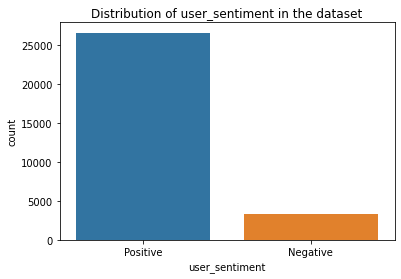

In [ ]:
sns.countplot(x='user_sentiment',data=data_ebuss)
plt.title('Distribution of user_sentiment in the dataset')
plt.show()

##### Takeaway :

Comparatively there are few negative reviews , which indicates class imbalance which should handled later during training of the model

##### To understand distribution of ratings

In [ ]:
data_ebuss['reviews_rating'].value_counts()

5    20831
4     6020
1     1384
3     1345
2      420
Name: reviews_rating, dtype: int64

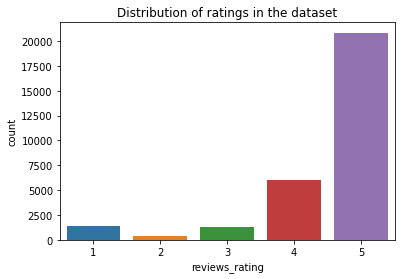

In [ ]:
sns.countplot(x='reviews_rating',data=data_ebuss)
plt.title('Distribution of ratings in the dataset')
plt.show()

##### Takeaway:
Majority products are high-rated products which supports the dominance in the sentiment as well.

##### To understand word frequency and also to have a glimpse at what words are being used

In this particular wordCloud we have used the data without filtering w.r.t to the sentiment. 

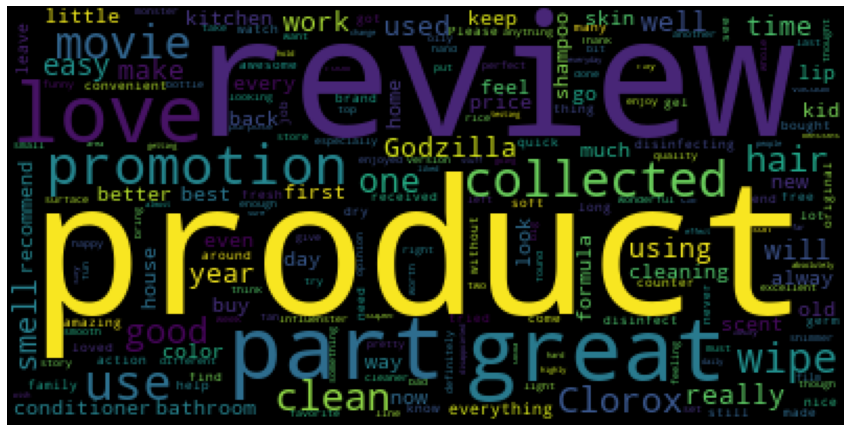

In [104]:
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,collocations=False).generate(' '.join(data_ebuss['reviews_text']))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

In this particular wordcloud 'POSITIVE' user sentiment is considered.

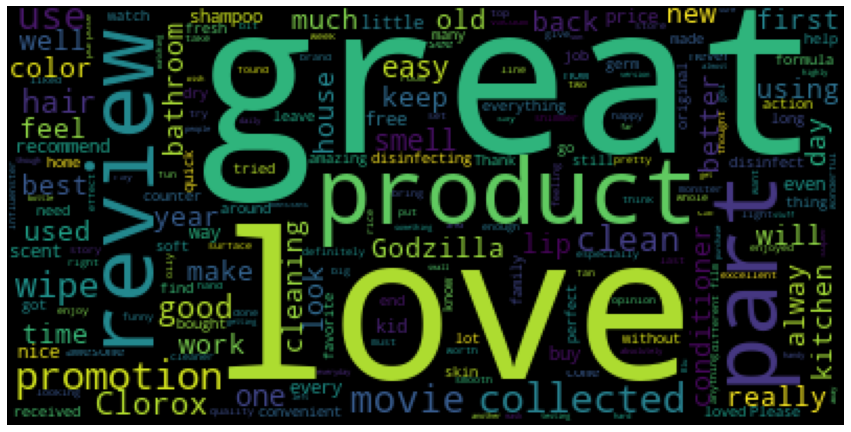

In [105]:
wordcloud = WordCloud(stopwords=stopwords,collocations=False).generate(' '.join(data_ebuss[data_ebuss['user_sentiment']=='Positive']['reviews_text']))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Takeaway:
We can see that a lot of positive adjectives are being used here.

In this wordCloud negative user sentiment is being considered 

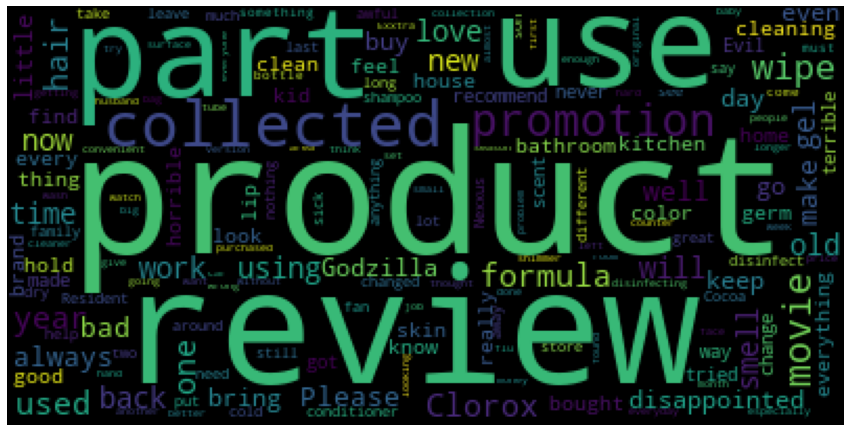

In [106]:
wordcloud = WordCloud(stopwords=stopwords,collocations=False).generate(' '.join(data_ebuss[data_ebuss['user_sentiment']=='Negative']['reviews_text']))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Takeaway:
Upon looking keenly we can find few adjectives which align with the negative sentiment.

In this wordClound we are only considering the title of the review

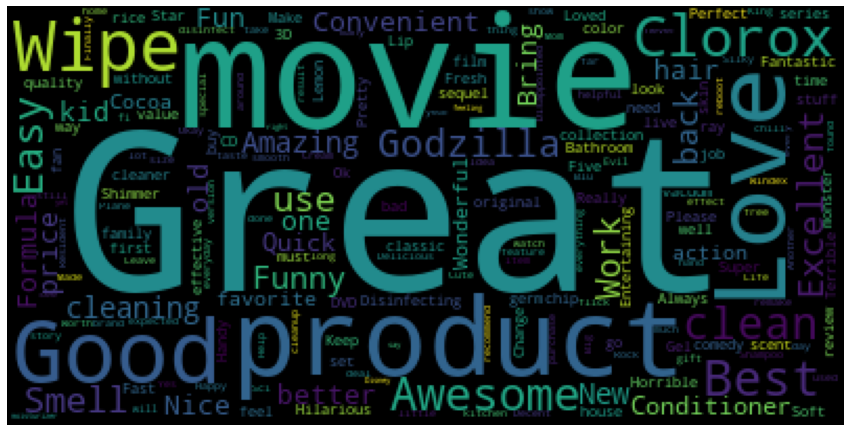

In [107]:
wordcloud = WordCloud(stopwords=stopwords,collocations=False).generate(' '.join(data_ebuss['reviews_title'].fillna('')))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Takeaway:
There are few adjectives also majority are addressing to the product name

##### Considering Brand

In [108]:
data_ebuss.brand.value_counts()

Clorox                   10585
Warner Home Video         3325
Disney                    1200
L'oreal Paris             1186
FOX                        887
                         ...  
Pacific Natural Foods        1
Noosa                        1
Southern Enterprises         1
SLOAN VALVE COMPANY          1
Universal Music              1
Name: brand, Length: 214, dtype: int64

Plotting for distribution of TOP-10 brands

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


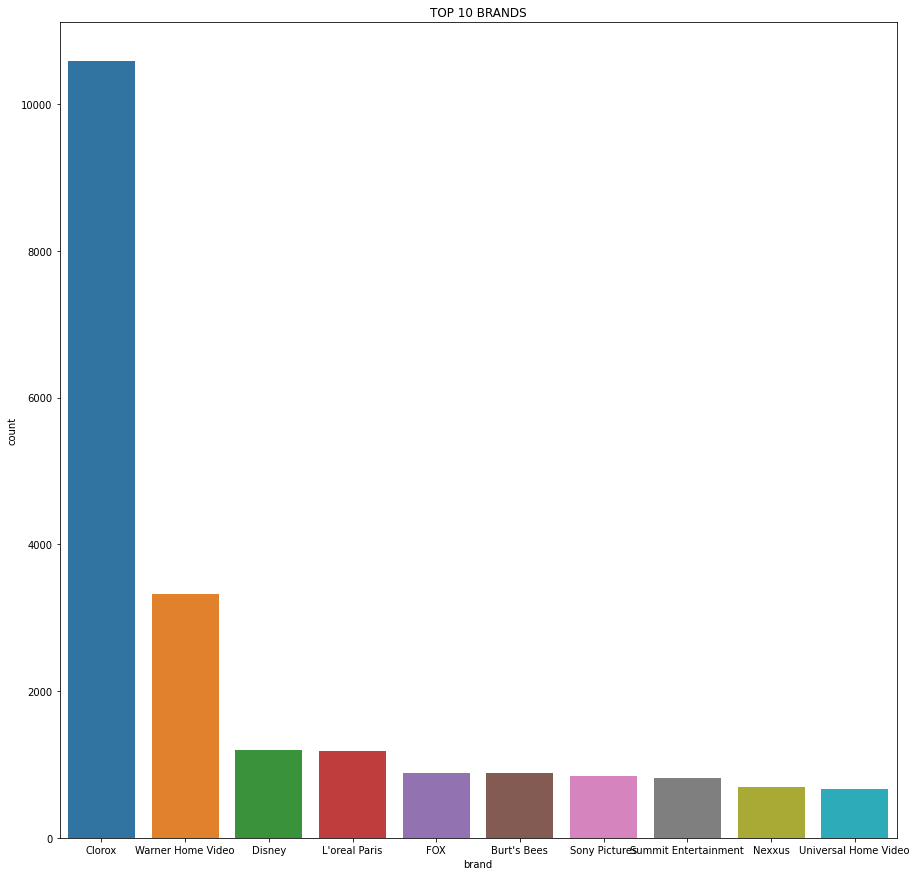

In [112]:
plt.figure(figsize=(15,15))
sns.countplot(data_ebuss['brand'], order=pd.value_counts(data_ebuss['brand']).iloc[:10].index)
plt.title('TOP 10 BRANDS')
plt.show()

##### Takeaway: 
This shows the brand dominance by few brands on the market aka dataset.

In [ ]:
data_ebuss.info() # having a glimpse at the data info

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 15 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   id                    30000 non-null  object
 1   brand                 30000 non-null  object
 2   categories            30000 non-null  object
 3   manufacturer          29859 non-null  object
 4   name                  30000 non-null  object
 5   reviews_date          29954 non-null  object
 6   reviews_didPurchase   15932 non-null  object
 7   reviews_doRecommend   27430 non-null  object
 8   reviews_rating        30000 non-null  int64 
 9   reviews_text          30000 non-null  object
 10  reviews_title         29810 non-null  object
 11  reviews_userCity      1929 non-null   object
 12  reviews_userProvince  170 non-null    object
 13  reviews_username      29937 non-null  object
 14  user_sentiment        29999 non-null  object
dtypes: int64(1), object(14)
memory usage

In [ ]:
data_ebuss.shape #checking rows and cols

(30000, 15)

In [ ]:
data_ebuss.nunique() #no of unique values present for respective columns 

id                        271
brand                     214
categories                270
manufacturer              227
name                      271
reviews_date             6857
reviews_didPurchase         2
reviews_doRecommend         2
reviews_rating              5
reviews_text            27282
reviews_title           18535
reviews_userCity          977
reviews_userProvince       42
reviews_username        24914
user_sentiment              2
dtype: int64

In [ ]:
data_ebuss.drop_duplicates().shape # checking to see if there are any duplicates

(30000, 15)

No duplicates as of now 

In [ ]:
data_ebuss = data_ebuss.drop_duplicates() # dropping the duplicates

In [ ]:
help(pd.read_csv)

Help on function read_csv in module pandas.io.parsers.readers:

read_csv(filepath_or_buffer: 'FilePathOrBuffer', sep=<no_default>, delimiter=None, header='infer', names=<no_default>, index_col=None, usecols=None, squeeze=False, prefix=<no_default>, mangle_dupe_cols=True, dtype: 'DtypeArg | None' = None, engine=None, converters=None, true_values=None, false_values=None, skipinitialspace=False, skiprows=None, skipfooter=0, nrows=None, na_values=None, keep_default_na=True, na_filter=True, verbose=False, skip_blank_lines=True, parse_dates=False, infer_datetime_format=False, keep_date_col=False, date_parser=None, dayfirst=False, cache_dates=True, iterator=False, chunksize=None, compression='infer', thousands=None, decimal: 'str' = '.', lineterminator=None, quotechar='"', quoting=0, doublequote=True, escapechar=None, comment=None, encoding=None, encoding_errors: 'str | None' = 'strict', dialect=None, error_bad_lines=None, warn_bad_lines=None, on_bad_lines=None, delim_whitespace=False, low_me

###### Reading the data description file for better understanding

In [ ]:
desc_col = pd.read_csv('/content/gdrive/MyDrive/Colab Notebooks/capstone/Data+Attribute+Description.csv',encoding='ISO-8859-1')

In [ ]:
desc_col

,Attribute,Attribute Description
0,id,Uniques identity number to identify each unique review given by the user to a particular product in the dataset
1,brand,Name of the brand of the product to which user has given review and rating
2,categories,"Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more."
3,manufacturer,Name of the manufacturer of the product
4,name,Name of the product to which user has added review or rating
5,reviews_date,Date on which the review has been added by the user
6,reviews_didPurchase,Whether a particular user has purchased the product or not
7,reviews_doRecommend,Whether a particular user has recommended the product or not
8,reviews_rating,Rating given by the user to a particular product
9,reviews_text,Review given by the user to a particular product


#### Understanding
- If they would help the analysis how and why

<table border="1" class="dataframe">  <thead>    <tr style="text-align: right;">      <th></th>      <th>Attribute</th>      <th>Attribute Description</th>      <th>Would they be useful for analysis ?</th>      <th>Reason</th>    </tr>  </thead>  <tbody>    <tr>      <th>0</th>      <td>id</td>      <td>Uniques identity number to identify each unique review given by the user to a particular product in the dataset</td>      <td>True</td>      <td>Nothing</td>    </tr>    <tr>      <th>1</th>      <td>brand</td>      <td>Name of the brand of the product to which user has given review and rating</td>      <td>True</td>      <td>Helpful</td>    </tr>    <tr>      <th>2</th>      <td>categories</td>      <td>Category of the product like household essentials, books, personal care products, medicines, cosmetic items, beauty products, electrical appliances, kitchen and dining products, health care products and many more.</td>      <td>False</td>      <td>Would make things complex</td>    </tr>    <tr>      <th>3</th>      <td>manufacturer</td>      <td>Name of the manufacturer of the product</td>      <td>False</td>      <td>Not at all required</td>    </tr>    <tr>      <th>4</th>      <td>name</td>      <td>Name of the product to which user has added review or rating</td>      <td>True</td>      <td>Helpful</td>    </tr>    <tr>      <th>5</th>      <td>reviews_date</td>      <td>Date on which the review has been added by the user</td>      <td>False</td>      <td>Dates do not help us</td>    </tr>    <tr>      <th>6</th>      <td>reviews_didPurchase</td>      <td>Whether a particular user has purchased the product or not</td>      <td>False</td>      <td>Flags do not help us</td>    </tr>    <tr>      <th>7</th>      <td>reviews_doRecommend</td>      <td>Whether a particular user has recommended the product or not</td>      <td>False</td>      <td>Flags do not help us</td>    </tr>    <tr>      <th>8</th>      <td>reviews_rating</td>      <td>Rating given by the user to a particular product</td>      <td>True</td>      <td>Crucial for Analysis</td>    </tr>    <tr>      <th>9</th>      <td>reviews_text</td>      <td>Review given by the user to a particular product</td>      <td>True</td>      <td>Crucial for Analysis</td>    </tr>    <tr>      <th>10</th>      <td>reviews_title</td>      <td>The title of the review given by the user to a particular product</td>      <td>True</td>      <td>Crucial for Analysis</td>    </tr>    <tr>      <th>11</th>      <td>reviews_userCity</td>      <td>The residing city of the user</td>      <td>False</td>      <td>What we do has no dependency on location</td>    </tr>    <tr>      <th>12</th>      <td>reviews_userProvince</td>      <td>The residing province of the user</td>      <td>False</td>      <td>What we do has no dependency on location</td>    </tr>    <tr>      <th>13</th>      <td>reviews_username</td>      <td>The unique identification for individual user in the dataset</td>      <td>True</td>      <td>Crucial for Analysis</td>    </tr>    <tr>      <th>14</th>      <td>user_sentiment</td>      <td>The overall sentiment of the user for a particular product (Positive or Negative)</td>      <td>True</td>      <td>Target for the Sentiment Analysis</td>    </tr>  </tbody></table>

In [ ]:
cols_unwanted = ['categories',
 'manufacturer',
 'reviews_date',
 'reviews_didPurchase',
 'reviews_doRecommend',
 'reviews_userCity',
 'reviews_userProvince']
# Defining unwanted columns taking into consideration the above reason

In [ ]:
data_ebuss.drop(cols_unwanted, axis=1, inplace=True) # Dropping the unwanted columns
data_ebuss.shape

(30000, 8)

In [ ]:
data_ebuss.drop_duplicates(inplace=True) # dropping duplicate rows now 

In [ ]:
data_ebuss.shape # checking the shape

(29721, 8)

No of duplicates : 279 Duplicates (30k - 29721)

##### Checking nulls for username

In [ ]:
data_ebuss.isnull().sum() # checking null values

id                    0
brand                 0
name                  0
reviews_rating        0
reviews_text          0
reviews_title       190
reviews_username     63
user_sentiment        1
dtype: int64

In [ ]:
data_ebuss['reviews_username'].value_counts()

byamazon customer    41
mike                 41
chris                32
lisa                 16
tony                 15
                     ..
kimmycole             1
becca14               1
amberinco             1
lindam                1
kcoopxoxo             1
Name: reviews_username, Length: 24914, dtype: int64

In [ ]:
data_ebuss = data_ebuss[~data_ebuss.reviews_username.isna()] # dropping rows with no username

Initially dropping rows with no username because they would create rather more confusion upon replacement and they would not be of much use without username in further analysis and also constitute to very less amount of percentage.

In [ ]:
data_ebuss.shape # Checking the shape

(29658, 8)

No of rows with no username : 29721-29658 = 63 

##### Moving over to user_sentiment

In [ ]:
data_ebuss.isnull().sum() # checking no of null values

id                    0
brand                 0
name                  0
reviews_rating        0
reviews_text          0
reviews_title       189
reviews_username      0
user_sentiment        1
dtype: int64

Going ahead with the user sentiment

In [ ]:
data_ebuss[data_ebuss['user_sentiment'].isna()] # looking at the data for the corresponding row

,id,brand,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment
28354,AVpfRTh1ilAPnD_xYic2,Disney,Planes: Fire Rescue (2 Discs) (includes Digital Copy) (blu-Ray/dvd),5,my kids absolutely loved this film so much that we watched it twice. Having a digital copy means that every time we get in the car we get to watch it wherever we go. we even got to use our $5 reward coupon towards the purchase of this movie so we got an additional $5 off + we got to add the points towards our next rewards coupon we love the savings we get at Best Buy,a super hit with my children. they loved it!!??,7.87E+11,NaN


This certainly looks like a positive review

In [ ]:
data_ebuss['user_sentiment'].value_counts(dropna=False) # Checking value counts including null(NaN)

Positive    26329
Negative     3328
NaN             1
Name: user_sentiment, dtype: int64

In [ ]:
data_ebuss.isnull().sum()

id                    0
brand                 0
name                  0
reviews_rating        0
reviews_text          0
reviews_title       189
reviews_username      0
user_sentiment        1
dtype: int64

This looks like a positive review so changing it to Positive

In [ ]:
data_ebuss.user_sentiment.fillna('Positive',inplace=True) # replacing it with Positive

In [ ]:
data_ebuss.user_sentiment.value_counts()

Positive    26330
Negative     3328
Name: user_sentiment, dtype: int64

#### Cleaning up reviews title

In [ ]:
data_ebuss.isnull().sum() # checking no of null values

id                    0
brand                 0
name                  0
reviews_rating        0
reviews_text          0
reviews_title       189
reviews_username      0
user_sentiment        0
dtype: int64

Replacing na with empty string as title would not effect much , so an empty string would be an apt solution.

In [ ]:
data_ebuss.reviews_title.value_counts(dropna=False)

Great Product                    369
Great movie                      361
Clorox Wipes                     269
Great                            216
Great product                    205
                                ... 
Smells great - cleans too          1
absolutely love these wipes        1
maggie                             1
Powerful cleanng + good value      1
Conditioned into healthy           1
Name: reviews_title, Length: 18491, dtype: int64

In [ ]:
data_ebuss.reviews_title.fillna('',inplace=True) #replacing Nan with empty string

In [ ]:
data_ebuss.reviews_title.value_counts(dropna=False) # checking value counts

Great Product                    369
Great movie                      361
Clorox Wipes                     269
Great                            216
Great product                    205
                                ... 
Smells great - cleans too          1
absolutely love these wipes        1
maggie                             1
Powerful cleanng + good value      1
Conditioned into healthy           1
Name: reviews_title, Length: 18491, dtype: int64

In [ ]:
data_ebuss.isnull().sum() # checking null values again

id                  0
brand               0
name                0
reviews_rating      0
reviews_text        0
reviews_title       0
reviews_username    0
user_sentiment      0
dtype: int64

As there are no null values , going forward to the other prospects of data cleaning.

For processing purposes , to reduce load or weights being assigned we can combine reviews_title and reviews_text

In [ ]:
data_ebuss['review_modified'] = data_ebuss['reviews_title']+' '+data_ebuss['reviews_text'] # Combining title & text

In [ ]:
data_ebuss.head() 

,id,brand,name,reviews_rating,reviews_text,reviews_title,reviews_username,user_sentiment,review_modified
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.,Just Awesome,joshua,Positive,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor. This review was collected as part of a promotion.,Good,dorothy w,Positive,Good Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,Good flavor.,Good,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,"I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess.",Disappointed,rebecca,Negative,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.,Irritation,walker557,Negative,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [ ]:
data_ebuss.drop(['reviews_title','reviews_text'], axis=1, inplace=True) # dropping the other two as we have review_modified

In [ ]:
data_ebuss.head()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,review_modified
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,Just Awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. SO HYPE! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor. This review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,Good Good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,"Disappointed I read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews I had read. For starters, neither my boyfriend nor I could notice any sort of enhanced or 'captivating' sensation. What we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. It was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. I'm disappointed that I paid as much as I did for a lube that I won't use again, when I could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,Irritation My husband bought this gel for us. The gel caused irritation and it felt like it was burning my skin. I wouldn't recommend this gel.


In [ ]:
data_ebuss.info() # checking rows and columns 

<class 'pandas.core.frame.DataFrame'>
Int64Index: 29658 entries, 0 to 29999
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   id                29658 non-null  object
 1   brand             29658 non-null  object
 2   name              29658 non-null  object
 3   reviews_rating    29658 non-null  int64 
 4   reviews_username  29658 non-null  object
 5   user_sentiment    29658 non-null  object
 6   review_modified   29658 non-null  object
dtypes: int64(1), object(6)
memory usage: 1.8+ MB


## TEXT PROCESSING

In [ ]:
text_data_ebuss = data_ebuss.copy() # copying dataset for text processing

##### Converting them to lower case 

In [ ]:
text_data_ebuss['review_modified'] = text_data_ebuss['review_modified'].apply(lambda x : str(x).lower())

In [ ]:
text_data_ebuss.head()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,review_modified
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,just awesome i love this album. it's very good. more to the hip hop side than her current pop sound.. so hype! i listen to this everyday at the gym! i give it 5star rating all the way. her metaphors are just crazy.
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor. this review was collected as part of a promotion.
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor.
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,"disappointed i read through the reviews on here before looking in to buying one of the couples lubricants, and was ultimately disappointed that it didn't even live up to the reviews i had read. for starters, neither my boyfriend nor i could notice any sort of enhanced or 'captivating' sensation. what we did notice, however, was the messy consistency that was reminiscent of a more liquid-y vaseline. it was difficult to clean up, and was not a pleasant, especially since it lacked the 'captivating' sensation we had both been expecting. i'm disappointed that i paid as much as i did for a lube that i won't use again, when i could just use their normal personal lubricant for 1) less money and 2) less mess."
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,irritation my husband bought this gel for us. the gel caused irritation and it felt like it was burning my skin. i wouldn't recommend this gel.


In [ ]:
text_data_ebuss.tail()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,review_modified
29995,AVpfW8y_LJeJML437ySW,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,laurasnchz,Positive,"softness!! i got this conditioner with influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! this review was collected as part of a promotion."
29996,AVpfW8y_LJeJML437ySW,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,scarlepadilla,Positive,"i love it i love it , i received this for review purposes from influenster and it leaves my hair feeling fresh and smelling great"
29997,AVpfW8y_LJeJML437ySW,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,liviasuexo,Positive,hair is so smooth after use first of all i love the smell of this product. after you wash your hair it is so smooth and easy to brush! i did receive this product from influenster for testing purposes but all opinions are my own! this review was collected as part of a promotion.
29998,AVpfW8y_LJeJML437ySW,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,ktreed95,Positive,"perfect for my oily hair! i received this through influenster and will never go back to anything else! i normally don't use conditioner because my hair is so oily and fine. this does not make my hair feel heavy, and it doesn't get oily during the day! it really is fantastic and plan on buying it in the future! this review was collected as part of a promotion."
29999,AVpfW8y_LJeJML437ySW,L'oreal Paris,L'or233al Paris Elvive Extraordinary Clay Rebalancing Conditioner - 12.6 Fl Oz,5,kcoopxoxo,Positive,conditioned into healthy i received this product complimentary from influenster and it has really saved my hair. this product really gives the extra boost of health and strength to bring hair back to life. it hasn't helped my hair in so many ways. this review was collected as part of a promotion.


##### Removing special characters

In [ ]:
sample_text = 'softness!! i got this conditioner with influenster to try it and im loving it so far, i have oily hair so i use it only in the ends of my hair and feels amazing, so soft and no mess!! this review was collected as part of a promotion.'
# testing out on a sample text

In [ ]:
text_after_rem_punc = re.sub(r"[^A-Za-z0-9\s]",'',sample_text)
text_after_rem_punc # using regex sub method

'softness i got this conditioner with influenster to try it and im loving it so far i have oily hair so i use it only in the ends of my hair and feels amazing so soft and no mess this review was collected as part of a promotion'

In [ ]:
s_text = '__ujjna hello 90 JEEll'
text_after_rem = re.sub(r"[^A-Za-z0-9\s]",'',s_text)
text_after_rem

'ujjna hello 90 JEEll'

#### NOTE:
not using \w because it has _ included in it 

In [ ]:
text_data_ebuss['review_modified'] = text_data_ebuss['review_modified'].apply(lambda x: re.sub(r"[^A-Za-z0-9\s]",'',x))

In [ ]:
text_data_ebuss.head()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,review_modified
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,just awesome i love this album its very good more to the hip hop side than her current pop sound so hype i listen to this everyday at the gym i give it 5star rating all the way her metaphors are just crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor this review was collected as part of a promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,disappointed i read through the reviews on here before looking in to buying one of the couples lubricants and was ultimately disappointed that it didnt even live up to the reviews i had read for starters neither my boyfriend nor i could notice any sort of enhanced or captivating sensation what we did notice however was the messy consistency that was reminiscent of a more liquidy vaseline it was difficult to clean up and was not a pleasant especially since it lacked the captivating sensation we had both been expecting im disappointed that i paid as much as i did for a lube that i wont use again when i could just use their normal personal lubricant for 1 less money and 2 less mess
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel


##### Removing StopWords

In [ ]:
stop_words = stopwords.words('english')
stop_words

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [ ]:
sample_review = 'irritation my husband bought this gel for us the gel caused irritation and it felt like it was burning my skin i wouldnt recommend this gel'
# Trying it out on a sample review 

In [ ]:
" ".join([word for word in sample_review.split() if word not in stop_words])

'irritation husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel'

In [ ]:
text_data_ebuss['review_modified'] = text_data_ebuss['review_modified'].apply(lambda x:" ".join([word for word in x.split() if word not in stop_words]))

In [ ]:
text_data_ebuss.head()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,review_modified
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphors crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,disappointed read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant 1 less money 2 less mess
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,irritation husband bought gel us gel caused irritation felt like burning skin wouldnt recommend gel


##### Lemmatization

In [ ]:
lemmatizer = WordNetLemmatizer()

Before Lemma

In [2]:
sample_before_lemma = 'disappointed read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant 1 less money 2 less mess'
sample_before_lemma # trying it out on a sample

'disappointed read reviews looking buying one couples lubricants ultimately disappointed didnt even live reviews read starters neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant 1 less money 2 less mess'

After Lemma

In [ ]:
' '.join([lemmatizer.lemmatize(word) for word in sample_before_lemma.split()])

'disappointed read review looking buying one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant 1 le money 2 le mess'

In [ ]:
text_data_ebuss['review_modified'] = text_data_ebuss['review_modified'].apply(lambda x:' '.join([lemmatizer.lemmatize(word) for word in x.split()]))

In [ ]:
text_data_ebuss.head()

,id,brand,name,reviews_rating,reviews_username,user_sentiment,review_modified
0,AV13O1A8GV-KLJ3akUyj,Universal Music,Pink Friday: Roman Reloaded Re-Up (w/dvd),5,joshua,Positive,awesome love album good hip hop side current pop sound hype listen everyday gym give 5star rating way metaphor crazy
1,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor review collected part promotion
2,AV14LG0R-jtxr-f38QfS,Lundberg,Lundberg Organic Cinnamon Toast Rice Cakes,5,dorothy w,Positive,good good flavor
3,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,rebecca,Negative,disappointed read review looking buying one couple lubricant ultimately disappointed didnt even live review read starter neither boyfriend could notice sort enhanced captivating sensation notice however messy consistency reminiscent liquidy vaseline difficult clean pleasant especially since lacked captivating sensation expecting im disappointed paid much lube wont use could use normal personal lubricant 1 le money 2 le mess
4,AV16khLE-jtxr-f38VFn,K-Y,K-Y Love Sensuality Pleasure Gel,1,walker557,Negative,irritation husband bought gel u gel caused irritation felt like burning skin wouldnt recommend gel


In [ ]:
# Saving this in a pickle file for future purposes
now = datetime.now().strftime("%Y%m%d_%H%M")
pickle.dump(text_data_ebuss, open(f'TextProcessedData_{now}.pkl', 'wb'))
print("text_processed_df Saved as: TextProcessedData_{0}.pkl".format(now))

text_processed_df Saved as: TextProcessedData_20220322_2004.pkl


#### EDA on Processed-Data

Performing EDA on processed data to understand frequency on important words and their usage with regards to the sentiment.

WordCLoud for review_modified where user_sentiment is Positive

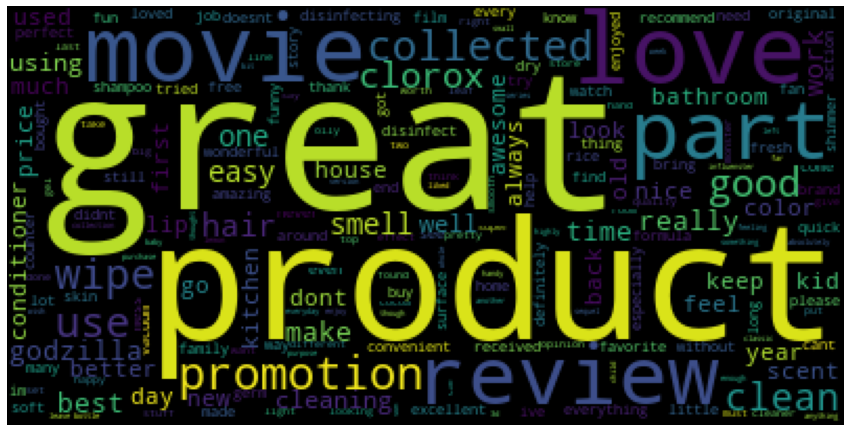

In [ ]:
# EDA before sentiment analysis
stopwords = set(STOPWORDS)
wordcloud = WordCloud(stopwords=stopwords,collocations=False).generate(' '.join(text_data_ebuss[text_data_ebuss['user_sentiment']=='Positive']['review_modified']))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Takeaway:
More refined adjectives in their root form 

WordCloud for review_modified where user_sentiment is Negative

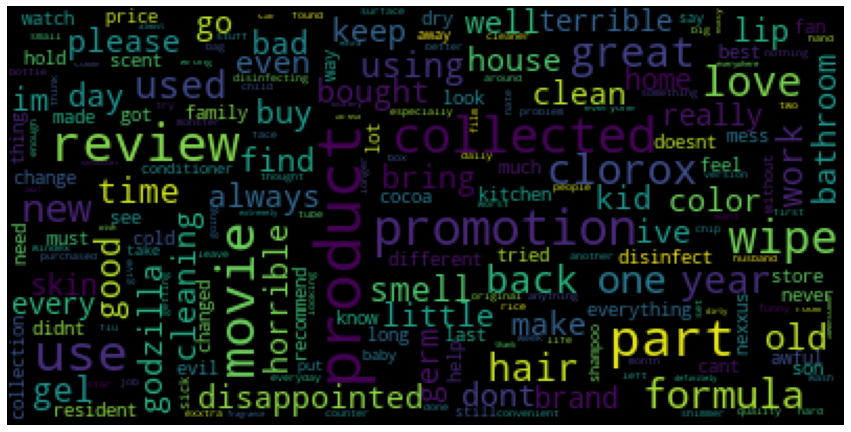

In [ ]:
wordcloud = WordCloud(stopwords=stopwords,collocations=False, max_font_size=30).generate(' '.join(text_data_ebuss[text_data_ebuss['user_sentiment']=='Negative']['review_modified']))
plt.figure(figsize=(15,15))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

##### Takeaway:
More adjectives which indicate the sentiment

## Sentiment Analysis

In [ ]:
sentiment_anal_cols = ['review_modified','user_sentiment'] # we need only two columns for this purpose

In [ ]:
df_sentiment = text_data_ebuss[sentiment_anal_cols].copy() # copying required sub-set of text_data_ebuss
df_sentiment.head()

,review_modified,user_sentiment
0,awesome love album good hip hop side current p...,Positive
1,good good flavor review collected part promotion,Positive
2,good good flavor,Positive
3,disappointed read review looking buying one co...,Negative
4,irritation husband bought gel u gel caused irr...,Negative


##### Mapping 

In [ ]:
df_sentiment['user_sentiment'] = df_sentiment['user_sentiment'].map({'Positive':1,'Negative':0})
df_sentiment.head()

,review_modified,user_sentiment
0,awesome love album good hip hop side current p...,1
1,good good flavor review collected part promotion,1
2,good good flavor,1
3,disappointed read review looking buying one co...,0
4,irritation husband bought gel u gel caused irr...,0


### Feature Extraction using tf-idf Vectorizer

In [ ]:
help(TfidfVectorizer)

Help on class TfidfVectorizer in module sklearn.feature_extraction.text:

class TfidfVectorizer(CountVectorizer)
 |  TfidfVectorizer(*, input='content', encoding='utf-8', decode_error='strict', strip_accents=None, lowercase=True, preprocessor=None, tokenizer=None, analyzer='word', stop_words=None, token_pattern='(?u)\\b\\w\\w+\\b', ngram_range=(1, 1), max_df=1.0, min_df=1, max_features=None, vocabulary=None, binary=False, dtype=<class 'numpy.float64'>, norm='l2', use_idf=True, smooth_idf=True, sublinear_tf=False)
 |  
 |  Convert a collection of raw documents to a matrix of TF-IDF features.
 |  
 |  Equivalent to :class:`CountVectorizer` followed by
 |  :class:`TfidfTransformer`.
 |  
 |  Read more in the :ref:`User Guide <text_feature_extraction>`.
 |  
 |  Parameters
 |  ----------
 |  input : {'filename', 'file', 'content'}, default='content'
 |      - If `'filename'`, the sequence passed as an argument to fit is
 |        expected to be a list of filenames that need reading to fetc

In [ ]:
tfidf_vectorizer =  TfidfVectorizer(ngram_range=(1,2)) # includes word_length 1,2
X = tfidf_vectorizer.fit_transform(df_sentiment['review_modified'])
y = df_sentiment['user_sentiment']

In [ ]:
# saving o/p from the vectorizer in a pickle file
now = datetime.now().strftime("%Y%m%d_%H%M")
pickle.dump(tfidf_vectorizer.vocabulary_, open(f'VectorizerFeatures_{now}.pkl', 'wb'))
print("vectorizer.vocabulary_ saved as: VectorizerFeatures_{0}.pkl".format(now))

vectorizer.vocabulary_ saved as: VectorizerFeatures_20220322_2007.pkl


In [ ]:
# Splitting into train-test
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size=0.8,random_state=30)
print(f' X-train shape --- {X_train.shape} \n y-train shape --- {y_train.shape} \n X-test shape --- {X_test.shape} \n y-test shape --- {y_test.shape}')

 X-train shape --- (23726, 240697) 
 y-train shape --- (23726,) 
 X-test shape --- (5932, 240697) 
 y-test shape --- (5932,)


In [ ]:
y_train.value_counts() # checking value_counts for user_sentiment

1    21057
0     2669
Name: user_sentiment, dtype: int64

There is very high class-imbalance which has to be handled

## Using SMOTE ( handling Class Imbalance)

- Perhaps the most widely used approach to synthesizing new examples is called the Synthetic Minority Oversampling TEchnique, or SMOTE for short.

- SMOTE works by selecting examples that are close in the feature space, drawing a line between the examples in the feature space and drawing a new sample at a point along that line.


In [ ]:
smote = SMOTE()
X_train, y_train = smote.fit_resample(X_train, y_train)

In [ ]:
y_train.value_counts() 

1    21057
0    21057
Name: user_sentiment, dtype: int64

SMOTE fixes our problem with Class Imbalance

##### Defining helper functions for model-building 

In [ ]:
help(f1_score)

Help on function f1_score in module sklearn.metrics._classification:

f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    Compute the F1 score, also known as balanced F-score or F-measure.
    
    The F1 score can be interpreted as a harmonic mean of the precision and
    recall, where an F1 score reaches its best value at 1 and worst score at 0.
    The relative contribution of precision and recall to the F1 score are
    equal. The formula for the F1 score is::
    
        F1 = 2 * (precision * recall) / (precision + recall)
    
    In the multi-class and multi-label case, this is the average of
    the F1 score of each class with weighting depending on the ``average``
    parameter.
    
    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    

In [ ]:
help(accuracy_score)

Help on function accuracy_score in module sklearn.metrics._classification:

accuracy_score(y_true, y_pred, *, normalize=True, sample_weight=None)
    Accuracy classification score.
    
    In multilabel classification, this function computes subset accuracy:
    the set of labels predicted for a sample must *exactly* match the
    corresponding set of labels in y_true.
    
    Read more in the :ref:`User Guide <accuracy_score>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) labels.
    
    y_pred : 1d array-like, or label indicator array / sparse matrix
        Predicted labels, as returned by a classifier.
    
    normalize : bool, default=True
        If ``False``, return the number of correctly classified samples.
        Otherwise, return the fraction of correctly classified samples.
    
    sample_weight : array-like of shape (n_samples,), default=None
        Sample weights.
    
    Ret

In [ ]:
help(f1_score)

Help on function f1_score in module sklearn.metrics._classification:

f1_score(y_true, y_pred, *, labels=None, pos_label=1, average='binary', sample_weight=None, zero_division='warn')
    Compute the F1 score, also known as balanced F-score or F-measure.
    
    The F1 score can be interpreted as a harmonic mean of the precision and
    recall, where an F1 score reaches its best value at 1 and worst score at 0.
    The relative contribution of precision and recall to the F1 score are
    equal. The formula for the F1 score is::
    
        F1 = 2 * (precision * recall) / (precision + recall)
    
    In the multi-class and multi-label case, this is the average of
    the F1 score of each class with weighting depending on the ``average``
    parameter.
    
    Read more in the :ref:`User Guide <precision_recall_f_measure_metrics>`.
    
    Parameters
    ----------
    y_true : 1d array-like, or label indicator array / sparse matrix
        Ground truth (correct) target values.
    

In [ ]:
help(roc_auc_score)

Help on function roc_auc_score in module sklearn.metrics._ranking:

roc_auc_score(y_true, y_score, *, average='macro', sample_weight=None, max_fpr=None, multi_class='raise', labels=None)
    Compute Area Under the Receiver Operating Characteristic Curve (ROC AUC)
    from prediction scores.
    
    Note: this implementation can be used with binary, multiclass and
    multilabel classification, but some restrictions apply (see Parameters).
    
    Read more in the :ref:`User Guide <roc_metrics>`.
    
    Parameters
    ----------
    y_true : array-like of shape (n_samples,) or (n_samples, n_classes)
        True labels or binary label indicators. The binary and multiclass cases
        expect labels with shape (n_samples,) while the multilabel case expects
        binary label indicators with shape (n_samples, n_classes).
    
    y_score : array-like of shape (n_samples,) or (n_samples, n_classes)
        Target scores.
    
        * In the binary case, it corresponds to an array 

In [ ]:
evaluation_df = pd.DataFrame(columns=['model', 'Accuracy(train)','Accuracy(test)', 'Sensitivity(train)','Sensitivity(test)','Specificity(train)','Specificity(test)','F1 (train)', 'F1 (test)',
                                     'AUC (train)', 'AUC (test)'])
# defining data-frame with columns

def model_evaluation(model, X_train, X_test, y_train, y_test):
    """ Helper function to assess the performance of the given model with the respective data """
    
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    
    accuracy_train = accuracy_score(y_train, train_pred)
    accuracy_test = accuracy_score(y_test, test_pred)
    cm_train = confusion_matrix(y_train, train_pred)
    cm_test = confusion_matrix(y_test, test_pred)
    sensitivity_train = cm_train[1][1]/sum(cm_train[1])
    sensitivity_test = cm_test[1][1]/sum(cm_test[1])
    specificity_train = cm_train[0][0]/sum(cm_train[0])
    specificity_test = cm_test[0][0]/sum(cm_test[0])
    f1_score_train = f1_score(y_train, train_pred)
    f1_score_test =f1_score(y_test, test_pred)
    roc_train = roc_auc_score(y_train, train_pred)
    roc_test = roc_auc_score(y_test, test_pred)
    
    global evaluation_df
    evaluation_df = evaluation_df.append({'model':type(model),'Accuracy(train)':accuracy_train,'Accuracy(test)': accuracy_test, 'Sensitivity(train)':sensitivity_train, 'Sensitivity(test)':sensitivity_test, 'Specificity(train)':specificity_train
                         ,'Specificity(test)': specificity_test, 'F1 (train)': f1_score_train,  'F1 (test)':f1_score_test,'AUC (train)': roc_train, 'AUC (test)': roc_test} , ignore_index=True)
    
    

##### Model I : Logistic Regression with no hyperparameter tuning

In [ ]:
lr = LogisticRegression(random_state=30)
lr.fit(X_train, y_train)

LogisticRegression(random_state=30)

In [ ]:
model_evaluation(lr, X_train, X_test, y_train, y_test)

In [ ]:
evaluation_df

,model,Accuracy(train),Accuracy(test),Sensitivity(train),Sensitivity(test),Specificity(train),Specificity(test),F1 (train),F1 (test),AUC (train),AUC (test)
0,<class 'sklearn.linear_model._logistic.Logisti...,0.98098,0.906271,0.966282,0.935331,0.995678,0.673748,0.980696,0.946641,0.98098,0.80454


##### Takeaway :
- All the params look good especially f1 and auc_roc 
- But coming to test params Specificity doesn't shine which means it could be better at predicting whether a review is -ve.

##### Model II : XGBoost

In [ ]:
help(XGBClassifier)

Help on class XGBClassifier in module xgboost.sklearn:

class XGBClassifier(XGBModel, sklearn.base.ClassifierMixin)
 |  XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100, verbosity=1, silent=None, objective='binary:logistic', booster='gbtree', n_jobs=1, nthread=None, gamma=0, min_child_weight=1, max_delta_step=0, subsample=1, colsample_bytree=1, colsample_bylevel=1, colsample_bynode=1, reg_alpha=0, reg_lambda=1, scale_pos_weight=1, base_score=0.5, random_state=0, seed=None, missing=None, **kwargs)
 |  
 |  Implementation of the scikit-learn API for XGBoost classification.
 |  
 |  Parameters
 |  ----------
 |  max_depth : int
 |      Maximum tree depth for base learners.
 |  learning_rate : float
 |      Boosting learning rate (xgb's "eta")
 |  n_estimators : int
 |      Number of trees to fit.
 |  verbosity : int
 |      The degree of verbosity. Valid values are 0 (silent) - 3 (debug).
 |  silent : boolean
 |      Whether to print messages while running boosting. Deprecat

In [ ]:
xg_boost = XGBClassifier(random_state=30)
xg_boost.fit(X_train, y_train)

XGBClassifier(random_state=30)

In [ ]:
model_evaluation(xg_boost, X_train, X_test, y_train, y_test)

In [ ]:
evaluation_df.loc[1]

model                 <class 'xgboost.sklearn.XGBClassifier'>
Accuracy(train)                                      0.853018
Accuracy(test)                                        0.83412
Sensitivity(train)                                   0.862848
Sensitivity(test)                                    0.857956
Specificity(train)                                   0.843188
Specificity(test)                                    0.643399
F1 (train)                                           0.854449
F1 (test)                                            0.901914
AUC (train)                                          0.853018
AUC (test)                                           0.750677
Name: 1, dtype: object

##### Takeaways: 
- Neither bad nor great.
- Only good thing is that there is very little difference in the train-test params except Specificity

##### Model III : Random Forest

In [ ]:
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble._forest:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='auto', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is controlled with the `max_samples` parameter if
 |  `bootstrap=True` (default), otherwise the whole dataset is used to build
 |  each tree.
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------


In [ ]:
random_forest_classifier = RandomForestClassifier(random_state=30)
random_forest_classifier.fit(X_train, y_train)

RandomForestClassifier(random_state=30)

In [ ]:
model_evaluation(random_forest_classifier, X_train, X_test, y_train, y_test)

In [ ]:
evaluation_df.loc[2]

model                 <class 'sklearn.ensemble._forest.RandomForestC...
Accuracy(train)                                                     1.0
Accuracy(test)                                                 0.901045
Sensitivity(train)                                                  1.0
Sensitivity(test)                                              0.989001
Specificity(train)                                                  1.0
Specificity(test)                                              0.197269
F1 (train)                                                          1.0
F1 (test)                                                      0.946719
AUC (train)                                                         1.0
AUC (test)                                                     0.593135
Name: 2, dtype: object

##### Takeaways: 
- Only good thing is that sensitivity is great.
- But Specificity and AUC for test look very bad.

##### Model IV: Naive Bayes

In [ ]:
help(MultinomialNB)

Help on class MultinomialNB in module sklearn.naive_bayes:

class MultinomialNB(_BaseDiscreteNB)
 |  MultinomialNB(*, alpha=1.0, fit_prior=True, class_prior=None)
 |  
 |  Naive Bayes classifier for multinomial models.
 |  
 |  The multinomial Naive Bayes classifier is suitable for classification with
 |  discrete features (e.g., word counts for text classification). The
 |  multinomial distribution normally requires integer feature counts. However,
 |  in practice, fractional counts such as tf-idf may also work.
 |  
 |  Read more in the :ref:`User Guide <multinomial_naive_bayes>`.
 |  
 |  Parameters
 |  ----------
 |  alpha : float, default=1.0
 |      Additive (Laplace/Lidstone) smoothing parameter
 |      (0 for no smoothing).
 |  
 |  fit_prior : bool, default=True
 |      Whether to learn class prior probabilities or not.
 |      If false, a uniform prior will be used.
 |  
 |  class_prior : array-like of shape (n_classes,), default=None
 |      Prior probabilities of the classe

In [ ]:
nb = MultinomialNB()
nb.fit(X_train, y_train)

MultinomialNB()

In [ ]:
model_evaluation(nb, X_train, X_test, y_train, y_test)

In [ ]:
evaluation_df.loc[3]

model                 <class 'sklearn.naive_bayes.MultinomialNB'>
Accuracy(train)                                          0.974023
Accuracy(test)                                           0.855698
Sensitivity(train)                                       0.950658
Sensitivity(test)                                        0.891712
Specificity(train)                                       0.997388
Specificity(test)                                        0.567527
F1 (train)                                               0.973401
F1 (test)                                                0.916569
AUC (train)                                              0.974023
AUC (test)                                                0.72962
Name: 3, dtype: object

##### Takeaways:
- Everything looks mediocre.
- Again not great specificity

##### Action:
- Keeping in mind the results of all models , the specificity and auc (Test) of only LR is comparatively great.
- Performing tuning on LR

##### Trying out the best model with Hyperparameter Tuning

In [ ]:
log_model = LogisticRegression(random_state=30)
param_grid = [    
    {'penalty' : ['l1', 'l2', 'elasticnet'],
    'C' : np.logspace(-2, 2, 20),
    'solver' : ['lbfgs','newton-cg','liblinear','sag','saga'],
    }
]

In [ ]:
clf = GridSearchCV(log_model, param_grid = param_grid, cv = 3, verbose=True, n_jobs=-1, scoring='roc_auc')

In [ ]:
best_clf = clf.fit(X_train,y_train)

Fitting 3 folds for each of 300 candidates, totalling 900 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
480 fits failed out of a total of 900.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 1461, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py", line 449, in _check_solver
    % (solver, penalty)
ValueError: Solv

In [ ]:
clf.best_params_

{'C': 100.0, 'penalty': 'l2', 'solver': 'liblinear'}

In [ ]:
final_lr = LogisticRegression(penalty='l2',solver='liblinear',C=100,random_state=30)
final_lr.fit(X_train, y_train)

LogisticRegression(C=100, random_state=30, solver='liblinear')

In [ ]:
model_evaluation(final_lr, X_train, X_test, y_train, y_test) # training on the best found hyper-parameters

In [ ]:
evaluation_df # looking at all the models and their scores collectively

,model,Accuracy(train),Accuracy(test),Sensitivity(train),Sensitivity(test),Specificity(train),Specificity(test),F1 (train),F1 (test),AUC (train),AUC (test)
0,<class 'sklearn.linear_model._logistic.Logisti...,0.980980,0.906271,0.966282,0.935331,0.995678,0.673748,0.980696,0.946641,0.980980,0.804540
1,<class 'xgboost.sklearn.XGBClassifier'>,0.853018,0.834120,0.862848,0.857956,0.843188,0.643399,0.854449,0.901914,0.853018,0.750677
2,<class 'sklearn.ensemble._forest.RandomForestC...,1.000000,0.901045,1.000000,0.989001,1.000000,0.197269,1.000000,0.946719,1.000000,0.593135
3,<class 'sklearn.naive_bayes.MultinomialNB'>,0.974023,0.855698,0.950658,0.891712,0.997388,0.567527,0.973401,0.916569,0.974023,0.729620
4,<class 'sklearn.linear_model._logistic.Logisti...,1.000000,0.919252,1.000000,0.973639,1.000000,0.484067,1.000000,0.955429,1.000000,0.728853


##### Conclusion:
- It clearly shows that LR is the winner.
- Although other models seem to have high accuracy they fail at auc and specificity .

In [ ]:
# Saving in a pickle file the first and best model LR
now = datetime.now().strftime("%Y%m%d_%H%M")
saved_model = pickle.dump(lr, open(f'LogisticRegressionModel_{now}.pkl', 'wb'))
print('Model Saved as: LogisticRegressionModel_{0}.pkl'.format(now))

Model Saved as: LogisticRegressionModel_20220322_2006.pkl


## Product Recommendation Engine
There are different parts for better discretion and understanding:
- User based recommendation
- User based prediction & evaluation
- Item based recommendation
- Item based prediction & evaluation

#### Col selection:
- Considering item aka id, user aka username , ratings

In [96]:
recommendation_columns = ['id', 'reviews_username', 'reviews_rating'] # Considering these recommendation columns
df_recom = data_ebuss[recommendation_columns].copy()

In [ ]:
df_recom.head() # having a glimpse at data

,id,reviews_username,reviews_rating
0,AV13O1A8GV-KLJ3akUyj,joshua,5
1,AV14LG0R-jtxr-f38QfS,dorothy w,5
2,AV14LG0R-jtxr-f38QfS,dorothy w,5
3,AV16khLE-jtxr-f38VFn,rebecca,1
4,AV16khLE-jtxr-f38VFn,walker557,1


In [ ]:
df_recom.shape

(29658, 3)

In [ ]:
df_recom.isnull().sum() # check for null values

id                  0
reviews_username    0
reviews_rating      0
dtype: int64

#### Dividing the dataset into train and test

In [ ]:
train_rat, test_rat = train_test_split(df_recom, train_size=0.8, random_state=30)
# Test and Train split of the dataset.

In [ ]:
print(train_rat.shape)
print(test_rat.shape)

(23726, 3)
(5932, 3)


In [ ]:
# Pivot the train ratings' dataset into matrix format in which columns item-ids and the rows are usernames.
df_pivot = train_rat.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating',fill_value=0
).fillna(0)

df_pivot.head(3)

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00sab00,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,1.0,0,0,0,3.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
02dakota,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0,0,0,0,0.0,0,0,0,0.0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


#### Creating dummy train & dummy test dataset
These dataset will be used for prediction 
- Dummy train will be used later for prediction of the items which has not been rated by the user. To ignore the movies rated by the user, we will mark it as 0 during prediction. The items not rated by user is marked as 1 for prediction in dummy train dataset. 

- Dummy test will be used for evaluation. To evaluate, we will only make prediction on the items rated by the user. So, this is marked as 1. This is just opposite of dummy_train.

In [ ]:
# Copy the train dataset into dummy_train
dummy_train = train_rat.copy()

In [ ]:
dummy_train['reviews_rating'].describe() # Checking min-value for the rating . 

count    23726.000000
mean         4.491992
std          0.975916
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: reviews_rating, dtype: float64

In [ ]:
# The movies not rated by user is marked as 1 for prediction. 
dummy_train['reviews_rating'] = dummy_train['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

In [ ]:
# Convert the dummy train dataset into matrix format.
dummy_train = dummy_train.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating',
    fill_value=1
).fillna(1)

In [ ]:
dummy_train.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
00sab00,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,0,1,1,1,0,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
02dakota,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
02deuce,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
0325home,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1


### Using Cosine Similarity ( User Similarity Matrix)

**Cosine Similarity**

Cosine Similarity is a measurement that quantifies the similarity between two vectors [Which is Rating Vector in this case] 

**Adjusted Cosine**

Adjusted cosine similarity is a modified version of vector-based similarity where we incorporate the fact that different users have different ratings schemes. In other words, some users might rate items highly in general, and others might give items lower ratings as a preference. To handle this nature from rating given by user , we subtract average ratings for each user from each user's rating for different items.



In [ ]:
# Create a user-item matrix.
df_pivot = train_rat.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

df_pivot.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Na

In [ ]:
# Normalising the rating of the movie for each user around 0 mean
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

In [ ]:
df_subtracted.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00sab00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.0,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02dakota,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
02deuce,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
0325home,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [ ]:
# Creating the User Similarity Matrix using pairwise_distance function.
# Finding cosine similarity
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
print(user_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 1. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
user_correlation.shape

(20437, 20437)

### Prediction - User User


Doing the prediction for the users which are positively related with other users, and not the users which are negatively related as we are interested in the users which are more similar to the current users. So, ignoring the correlation for values less than 0. 

In [ ]:
user_correlation[user_correlation<0]=0
user_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

Rating predicted by the user (for movies rated as well as not rated) is the weighted sum of correlation with the movie rating (as present in the rating dataset). 

In [ ]:
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 3.59536769, 0.59026035,
        0.20412415],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
user_predicted_ratings.shape

(20437, 258)

Since we are interested only in the items not rated by the user, we will ignore the items rated by the user by making it zero. 

In [ ]:
user_final_rating = np.multiply(user_predicted_ratings,dummy_train)
user_final_rating.head()

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000
00sab00,0.0,0.0,0.0,2.157568,0.0,0.0,0.0,0.742038,0.0,1.018079,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.078328,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.952702,0.0,0.0,0.0,0.0,0.0,2.700309,2.218218,0.0,0.0,0.0,0.0,0.0,2.309401,0.0,0.0,0.0,0.0,0.0,...,0.790569,0.0,0.0,0.0,0.545545,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816497,3.605259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.471521,3.594451,0.0,2.5,0.0,0.0,0.0,3.393684,0.0,0.0,0.0,0.708616,0.0,0.0,0.0,3.595368,0.59026,0.204124
02dakota,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.00000,0.000000
02deuce,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.000

### Evaluation - User User 

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the movie already rated by the user insead of predicting it for the item not rated by the user. 

In [ ]:
common = test_rat[test_rat.reviews_username.isin(train_rat.reviews_username)]
common.shape # getting the common usernames in train and test

(1327, 3)

In [ ]:
common.head()

,id,reviews_username,reviews_rating
23559,AVpfPaoqLJeJML435Xk9,tominator,4
20863,AVpfluP1ilAPnD_xejxO,shorty,5
6490,AVpf3VOfilAPnD_xjpun,cass,1
24773,AVpfPaoqLJeJML435Xk9,ducklove,5
21642,AVpfm8yiLJeJML43AYyu,weston t,1


In [ ]:
# convert this into user-item matrix.
common_user_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
# Convert the user_correlation matrix into dataframe.
user_correlation_df = pd.DataFrame(user_correlation)

user_correlation_df['reviews_username'] = df_subtracted.index
user_correlation_df.set_index('reviews_username',inplace=True)
user_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,20387,20388,20389,20390,20391,20392,20393,20394,20395,20396,20397,20398,20399,20400,20401,20402,20403,20404,20405,20406,20407,20408,20409,20410,20411,20412,20413,20414,20415,20416,20417,20418,20419,20420,20421,20422,20423,20424,20425,20426,20427,20428,20429,20430,20431,20432,20433,20434,20435,20436
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
00sab00,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02dakota,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
02deuce,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
0325home,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
list_name = common.reviews_username.tolist()

user_correlation_df.columns = df_subtracted.index.tolist()

user_correlation_df_1 =  user_correlation_df[user_correlation_df.index.isin(list_name)] # checking if present

user_correlation_df_2 = user_correlation_df_1.T[user_correlation_df_1.T.index.isin(list_name)] 

user_correlation_df_3 = user_correlation_df_2.T

user_correlation_df_3.head()

,1234asdf,143st,1943,37f5p,4cloroxl,4djs,7.87E+11,7inthenest,aac06002,aaron,abc,abcdefghij,ace24,acellacey,actionaction,acv4217,adamsmom,aep1010,afwifey2003,aj1135,ajune,akesler19,akhan,aktcharlotte,alena125,alex,alexis,alice,allen,allie,allison33,ally,aly16,amanda,amanda13,amandamueller,amandarose,amazing,amazon customer,amber,amber0528,amcomber,amgo2,ammcam,amy1,amyx3duh,anas79,anatnas4,andrea,andream82,...,tooney38,toothpick,torrie,tracelyn28,trav,treesmith,tricia,trish626,trisha,ttia,tw350z,twebb,twiggy575,twotone,tycr,val214,vanessavast,veroo,vick88,vicki,vickie,vickie456,vicocious,viewer,viking80,vikki,vivienne,vypkf0,walker,wally,warren,weston t,whome,wil27,wildchild23,wise,wjb1,wolf,wolfie,wolverine,wonderwoman,woody,woottos,worm,wowwie,yayawomack,yesseniaw22,yummy,zapman,zebras
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1943,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.57735,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.816497,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
37f5p,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4cloroxl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
user_correlation_df_3.shape

(1174, 1174)

In [ ]:
user_correlation_df_3[user_correlation_df_3<0]=0
common_user_predicted_ratings = np.dot(user_correlation_df_3, common_user_based_matrix.fillna(0))
common_user_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 3.83166253, ..., 3.16227766, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').fillna(0)
dummy_test.shape

(1174, 104)

In [ ]:
common_user_predicted_ratings = np.multiply(common_user_predicted_ratings,dummy_test)
common_user_predicted_ratings.head(2) 


id,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YneDPglJLPUi8IJyQ,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1h6Gu0glJLPUi8IjA_,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe7GIELJeJML43yZfu,AVpe7sl91cnluZ0-aI1Y,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe9W4D1cnluZ0-avf0,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,AVpe_pDG1cnluZ0-bjSf,AVpf--o9LJeJML43G_Fq,AVpf0YhQLJeJML43ETff,AVpf0eb2LJeJML43EVSt,AVpf0thK1cnluZ0-r8vR,AVpf2tw1ilAPnD_xjflC,AVpf385g1cnluZ0-s0_t,AVpf3VOfilAPnD_xjpun,AVpf3okQLJeJML43FMif,AVpf4oLxLJeJML43FcxC,AVpf5FF71cnluZ0-tHAV,AVpf5Z1zLJeJML43FpB-,AVpf5olc1cnluZ0-tPrO,AVpf63aJLJeJML43F__Q,AVpf7I3i1cnluZ0-tnL6,AVpf7LysilAPnD_xkm9G,AVpf7aUAilAPnD_xkqbP,AVpf9UGp1cnluZ0-uITX,...,AVpfBU2S1cnluZ0-cJsO,AVpfBpnEilAPnD_xTUBx,AVpfBrUZilAPnD_xTUly,AVpfD9xTLJeJML431ig2,AVpfDI3xilAPnD_xTz-k,AVpfFs_1ilAPnD_xUtRm,AVpfGRUHilAPnD_xU5nU,AVpfGuDrLJeJML432fDz,AVpfHI2filAPnD_xVL7R,AVpfIfnYilAPnD_xVpGi,AVpfIvbgLJeJML433Kph,AVpfJP1C1cnluZ0-e3Xy,AVpfLnfPLJeJML434HpK,AVpfM_ytilAPnD_xXIJb,AVpfMpZ51cnluZ0-f_L9,AVpfNVsj1cnluZ0-gNQN,AVpfNWbPilAPnD_xXPR7,AVpfOIrkilAPnD_xXgDG,AVpfOfIqLJeJML435D06,AVpfOmKwLJeJML435GM7,AVpfPPkEilAPnD_xX3cP,AVpfPaoqLJeJML435Xk9,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfUJu_ilAPnD_xZdDr,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfewoLilAPnD_xcfgU,AVpfhxaELJeJML43-zsM,AVpfi79RLJeJML43_Jo0,AVpfiUrfLJeJML43-9nY,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfr5cb1cnluZ0-pZFp,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1234asdf,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
143st,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
X  = common_user_predicted_ratings.copy() 
X = X[X>0]
# Calculating the RMSE for only the items rated by user. For RMSE, normalising the rating to (1,5) range.
scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))
print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating')
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))
rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

2.480320239244576


#### Takeaway :
- The rmse looks mediocre let's go ahead with Item based similarity.

## Item Based Similarity

Taking the transpose of the rating matrix to normalize the rating around the mean for different item ID. In the user based similarity, we had taken mean for each user instead of each item. 

In [ ]:
df_pivot = train_rat.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
).T

df_pivot.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,08dallas,09mommy11,1.11E+24,1085,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234567,1234asdf,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,132457,13thfaerie,1421nikki,143st,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1chynna,1clean1,1cleaner,1cocoafan,1disappoint,1friendlycat,1gamer,1glenn,...,zenanuts,zer0zer0agent,zetamom,zfem2,zhjwpp,ziana,zibber23,zibby4,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zodness,zoe1988,zoeellasca,zoey,zoeyny,zokhid,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zooey_57,zookeeper,zoomin76,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zuttle,zxcsdfd,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Normalising the movie rating for each movie for using the Adjusted Cosine

In [ ]:
mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

df_subtracted.head()

reviews_username,00dog3,00sab00,02dakota,02deuce,0325home,08dallas,09mommy11,1.11E+24,1085,11111111aaaaaaaaaaaaaaaaa,1143mom,1234,1234567,1234asdf,123charlie,123numbers,123rs,123soccermom,123too,127726,12cass12,132457,13thfaerie,1421nikki,143st,1515,15425shopper,1616,170361eggs,1753,17roses,18612,1863philly,1943,1968bear,1970,1979edes,1992firebirdgirl,19bubba67,19granny,1awesome1,1boomer,1chynna,1clean1,1cleaner,1cocoafan,1disappoint,1friendlycat,1gamer,1glenn,...,zenanuts,zer0zer0agent,zetamom,zfem2,zhjwpp,ziana,zibber23,zibby4,zillanator,zimmeyb,zina911,zink,zinnian,zipflip,zipp,zipperdoo,zippity,zippy,zitro,zittles,zkondrk,zman69,zmom,znxfyt,zodness,zoe1988,zoeellasca,zoey,zoeyny,zokhid,zombiedad80,zombiegirl22,zombiejess,zombiekiller,zombiekiller14,zone,zooey_57,zookeeper,zoomin76,zout22389,zowie,zozo0o,zpalma,zsazsa,zt313,zubb,zuttle,zxcsdfd,zzdiane,zzz1127
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV14LG0R-jtxr-f38QfS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV16khLE-jtxr-f38VFn,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YGDqsGV-KLJ3adc-O,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.148496,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AV1YIch7GV-KLJ3addeG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Finding the cosine similarity using pairwise distances approach

In [ ]:
# Item Similarity Matrix
item_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
item_correlation[np.isnan(item_correlation)] = 0
print(item_correlation)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 1. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]]


In [ ]:
item_correlation[item_correlation<0]=0
item_correlation

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])

### Prediction - Item Item

In [ ]:
item_predicted_ratings = np.dot((df_pivot.fillna(0).T),item_correlation)
item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00184739, 0.        ,
        0.        ],
       [0.        , 0.        , 0.01042273, ..., 0.00175757, 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.00119331, 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.00095464, 0.        ,
        0.        ]])

In [ ]:
item_final_rating = np.multiply(item_predicted_ratings,dummy_train)
item_final_rating.head()
# Filtering the rating only for the movies not rated by the user for recommendation

id,AV13O1A8GV-KLJ3akUyj,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YIch7GV-KLJ3addeG,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1YnUMYglJLPUi8IJpK,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1Yo6FPglJLPUi8IK3u,AV1YpiJvvKc47QAVguxy,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AV2AvGnjGV-KLJ3alTQH,AV2Avn5dGV-KLJ3alTjq,AV2BOOWS-jtxr-f39GPS,AVpe-M4-ilAPnD_xSF1K,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe3_ikilAPnD_xPykq,AVpe4-GPLJeJML43xmuY,AVpe41TqilAPnD_xQH3d,AVpe4Bq81cnluZ0-YwTN,AVpe4hlXLJeJML43xbrB,AVpe4pnBilAPnD_xQDeb,AVpe59io1cnluZ0-ZgDU,AVpe5AMsLJeJML43xnku,AVpe5JOgilAPnD_xQPfE,AVpe5Mv4ilAPnD_xQQyy,AVpe5WElLJeJML43xv4b,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5tC61cnluZ0-ZZ86,AVpe5ttZLJeJML43x4yO,AVpe6C3WLJeJML43yApY,AVpe6CHv1cnluZ0-ZhwN,...,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfgvkJLJeJML43-g1y,AVpfhpNkilAPnD_xdUZz,AVpfiRY_LJeJML43-8p9,AVpfiUrfLJeJML43-9nY,AVpfifml1cnluZ0-mjSb,AVpfjHuw1cnluZ0-mvrX,AVpfjauJLJeJML43_TKe,AVpfk4y7ilAPnD_xeTgd,AVpfkIiYilAPnD_xeEjr,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfksililAPnD_xePx_,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpflENxilAPnD_xeXFF,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmVnVLJeJML43AMqC,AVpfmjXGLJeJML43AQ5_,AVpfml2VilAPnD_xe0m6,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnUcwLJeJML43Af2U,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfozgyilAPnD_xfe0r,AVpfpM2yilAPnD_xfmDG,AVpfpoUCLJeJML43BLXv,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfs0tUilAPnD_xgqN2,AVpfsQoeilAPnD_xgfx5,AVpfshNsLJeJML43CB8q,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfv4TlilAPnD_xhjNS,AVpfvieo1cnluZ0-qdnu
reviews_username,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
00dog3,0.0,0.0,0.000000,0.017116,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.046732,0.0,0.000000,0.000000,0.026514,0.0,0.000000,0.0,0.0,0.000000,0.032076,0.0,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0
00sab00,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.003769,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.013244,0.0,0.0,0.0,0.000000,0.0,0.015253,0.060018,0.000000,0.0,0.007206,0.0,0.0,0.000000,0.007841,0.0,0.0,0.0,0.000000,...,0.005031,0.000000,0.005119,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.017272,0.002157,0.007413,0.000121,0.0,0.0,0.0,0.003716,0.000000,0.000000,0.0,0.0,0.0,0.0,0.031087,0.001847,0.0,0.0
02dakota,0.0,0.0,0.010423,0.000000,0.0,0.0,0.0,0.0,0.00000,0.000000,0.0,0.0,0.001116,0.0,0.0,0.001593,0.013091,0.001140,0.0,0.0,0.0,0.0,0.0,0.0,0.003706,0.0,0.0,0.0,0.0,0.0,0.000000,0.011493,0.0,0.0,0.0,0.009995,0.0,0.014508,0.000000,0.000000,0.0,0.006854,0.0,0.0,0.012736,0.000000,0.0,0.0,0.0,0.000000,...,0.000000,0.022949,0.003499,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.001877,0.0,0.0,0.0,0.017883,0.0,0.0,0.0,0.000000,0.001533,0.000000,0.006817,0.0,0.0,0.0,0.000000,0.124158,0.000000,0.0,0.0,0.0,0.0,0.000000,0.001758,0.0,0.0
02deuce,0.0,0.0,0

### Evaluation - Item Item

Evaluation will we same as you have seen above for the prediction. The only difference being, you will evaluate for the item aka product already rated by the user instead of predicting it for the item not rated by the user. 

In [ ]:
common =  test_rat[test_rat.id.isin(train_rat.id)]
common.shape

(5918, 3)

In [ ]:
common.head(4)

,id,reviews_username,reviews_rating
27583,AVpfRTh1ilAPnD_xYic2,haveachild,5
9339,AVpf3VOfilAPnD_xjpun,gd1400,5
21397,AVpfm8yiLJeJML43AYyu,nikola,1
26035,AVpfPaoqLJeJML435Xk9,cjl2674,5


In [ ]:
common_item_based_matrix = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T
common_item_based_matrix.shape

(179, 5638)

In [ ]:
item_correlation_df = pd.DataFrame(item_correlation)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013217,0.0,0.0,0.0,0.0,0.046267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010384,0.000695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002425,0.0,0.0,0.0,0.0,...,0.0,0.010384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001586,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00166,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [ ]:
item_correlation_df['id'] = df_subtracted.index
item_correlation_df.set_index('id',inplace=True)
item_correlation_df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,...,208,209,210,211,212,213,214,215,216,217,218,219,220,221,222,223,224,225,226,227,228,229,230,231,232,233,234,235,236,237,238,239,240,241,242,243,244,245,246,247,248,249,250,251,252,253,254,255,256,257
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV13O1A8GV-KLJ3akUyj,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AV16khLE-jtxr-f38VFn,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.013217,0.0,0.0,0.0,0.0,0.046267,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033015,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.010384,0.000695,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.002425,0.0,0.0,0.0,0.0,...,0.0,0.010384,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003841,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.001586,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00166,0.0,0.0
AV1YIch7GV-KLJ3addeG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0


In [ ]:
list_name = common.id.tolist()

item_correlation_df.columns = df_subtracted.index.tolist()

item_correlation_df_1 =  item_correlation_df[item_correlation_df.index.isin(list_name)]

item_correlation_df_2 = item_correlation_df_1.T[item_correlation_df_1.T.index.isin(list_name)]

item_correlation_df_3 = item_correlation_df_2.T

item_correlation_df_3.head()

,AV14LG0R-jtxr-f38QfS,AV16khLE-jtxr-f38VFn,AV1YGDqsGV-KLJ3adc-O,AV1YlENIglJLPUi8IHsX,AV1YmBrdGV-KLJ3adewb,AV1YmDL9vKc47QAVgr7_,AV1Ymf_rglJLPUi8II2v,AV1Yn94nvKc47QAVgtst,AV1Ynb3bglJLPUi8IJxJ,AV1YneDPglJLPUi8IJyQ,AV1YqAaMGV-KLJ3adiDj,AV1Ys0kTvKc47QAVgx1C,AV1YtGjdglJLPUi8IOfJ,AV1ZSp2uglJLPUi8IQFy,AV1ZT7GLglJLPUi8IQLI,AV1ZVIgy-jtxr-f31W9N,AV1d76w7vKc47QAVhCqn,AV1h6Gu0glJLPUi8IjA_,AV1h6gSl-jtxr-f31p40,AV1l8zRZvKc47QAVhnAv,AVpe-PJnLJeJML43ziaj,AVpe-ltS1cnluZ0-bL8w,AVpe31o71cnluZ0-YrSD,AVpe38Uy1cnluZ0-YuJR,AVpe41TqilAPnD_xQH3d,AVpe4hlXLJeJML43xbrB,AVpe59io1cnluZ0-ZgDU,AVpe5JOgilAPnD_xQPfE,AVpe5c23LJeJML43xybi,AVpe5s3RLJeJML43x4eA,AVpe5ttZLJeJML43x4yO,AVpe6CHv1cnluZ0-ZhwN,AVpe6FfKilAPnD_xQmHi,AVpe6FpaLJeJML43yBuP,AVpe6PCDLJeJML43yFQH,AVpe6n2_LJeJML43yOgE,AVpe71Vk1cnluZ0-aL_Z,AVpe78stLJeJML43ytOY,AVpe7GIELJeJML43yZfu,AVpe7jB8LJeJML43yj91,AVpe7sl91cnluZ0-aI1Y,AVpe7zdzLJeJML43yp3d,AVpe8dHWLJeJML43y4uG,AVpe8gsILJeJML43y6Ed,AVpe8xjUilAPnD_xRkxC,AVpe9W4D1cnluZ0-avf0,AVpe9vHs1cnluZ0-a4TU,AVpe_5U_ilAPnD_xSrxG,AVpe_N91LJeJML43z4jD,AVpe_dxlilAPnD_xSiHI,...,AVpfPnrU1cnluZ0-g9rL,AVpfQtEm1cnluZ0-hUpe,AVpfR5m0LJeJML436K3W,AVpfRE4tilAPnD_xYdo_,AVpfRM8dLJeJML4358wT,AVpfRTh1ilAPnD_xYic2,AVpfRYbSilAPnD_xYkD4,AVpfRoqcLJeJML436FqG,AVpfTVkcilAPnD_xZLts,AVpfUCiPilAPnD_xZai4,AVpfUJu_ilAPnD_xZdDr,AVpfUN2nilAPnD_xZeY3,AVpfUQZjilAPnD_xZfOU,AVpfVPh3ilAPnD_xZzW9,AVpfW8y_LJeJML437ySW,AVpf_rYe1cnluZ0-ut8Y,AVpfazX31cnluZ0-kbdl,AVpfbkyr1cnluZ0-kozI,AVpfbraG1cnluZ0-kqnn,AVpfcu821cnluZ0-k8ep,AVpfdYUZilAPnD_xcHuK,AVpfe3On1cnluZ0-lgn5,AVpfewoLilAPnD_xcfgU,AVpfiUrfLJeJML43-9nY,AVpfjHuw1cnluZ0-mvrX,AVpfk4y7ilAPnD_xeTgd,AVpfkQkcLJeJML43_kEC,AVpfkak01cnluZ0-nJj6,AVpfl6baLJeJML43AEQq,AVpfl6sF1cnluZ0-nmwC,AVpfldDlLJeJML43_7s_,AVpfliCoilAPnD_xegIr,AVpfluP1ilAPnD_xejxO,AVpfm8yiLJeJML43AYyu,AVpfmjXGLJeJML43AQ5_,AVpfnRuSilAPnD_xfB8l,AVpfnS4eLJeJML43AfZe,AVpfnjBILJeJML43AkO3,AVpfoSS51cnluZ0-oVH9,AVpfov9TLJeJML43A7B0,AVpfpM2yilAPnD_xfmDG,AVpfqW4WilAPnD_xf7a_,AVpfr5cb1cnluZ0-pZFp,AVpfrFDZLJeJML43Bmv0,AVpfrTyiLJeJML43BrSI,AVpfrfHF1cnluZ0-pRai,AVpfrgjFLJeJML43BvCc,AVpfthSailAPnD_xg3ON,AVpftikC1cnluZ0-p31V,AVpfvieo1cnluZ0-qdnu
id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
AV14LG0R-jtxr-f38QfS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AV16khLE-jtxr-f38VFn,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.020285,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.013217,0.0,0.000000,0.046267,0.0,0.0,0.0,0.0,0.0,0.00000,0.0
AV1YGDqsGV-KLJ3adc-O,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.033015,0.0,0.0,0.0,0.0,0.0,0.0,0.010384,0.000695,0.0,0.0,0.0,0.0,0.0,0.0,0.002425,0.0,0.0,0.004279,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00288,0.0,0.0,0.0,0.0,0.010384,0.0,0.0,0.0,0.0,0.0,0.0,0.003792,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.003841,0.0,0.0,0.0,0.0,0.0,0.001586,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.00166,0.0
AV1YlENIglJLPUi8IHsX,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.007165,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0

In [ ]:
item_correlation_df_3[item_correlation_df_3<0]=0

common_item_predicted_ratings = np.dot(item_correlation_df_3, common_item_based_matrix.fillna(0))
common_item_predicted_ratings

array([[0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00625364, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.00105454, 0.00119331, 0.        , ..., 0.00119331, 0.00047732,
        0.00119331],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [ ]:
common_item_predicted_ratings.shape

(179, 5638)

Dummy test will be used for evaluation. To evaluate, we will only make prediction on the movies rated by the user. So, this is marked as 1. This is just opposite of dummy_train

In [ ]:
dummy_test = common.copy()
dummy_test['reviews_rating'] = dummy_test['reviews_rating'].apply(lambda x: 1 if x>=1 else 0)
dummy_test = dummy_test.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T.fillna(0)
# The products not rated is marked as 0 for evaluation. And make the item- item matrix representaion.

common_item_predicted_ratings = np.multiply(common_item_predicted_ratings,dummy_test)
common_ = common.pivot_table(index='reviews_username', columns='id', values='reviews_rating').T

X  = common_item_predicted_ratings.copy() 
X = X[X>0]

scaler = MinMaxScaler(feature_range=(1, 5))
print(scaler.fit(X))
y = (scaler.transform(X))

print(y)

MinMaxScaler(feature_range=(1, 5))
[[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:461: RuntimeWarning: All-NaN slice encountered
  data_min = np.nanmin(X, axis=0)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_data.py:462: RuntimeWarning: All-NaN slice encountered
  data_max = np.nanmax(X, axis=0)


In [ ]:
# Finding total non-NaN value
total_non_nan = np.count_nonzero(~np.isnan(y))

rmse = (sum(sum((common_ - y )**2))/total_non_nan)**0.5
print(rmse)

3.564216711288841


##### Takeaway : 
- RMSE is comparatively higher than User based.

#### Conclusion :
- Going ahead with user-based similarity

In [97]:
# Copy the train dataset into dummy_
dummy_ = df_recom.copy()

# The products not rated by user is marked as 1 for prediction. 
dummy_['reviews_rating'] = dummy_['reviews_rating'].apply(lambda x: 0 if x>=1 else 1)

# # Convert the dummy train dataset into matrix format.
dummy_ = dummy_.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating',
    fill_value=1
)

# # Create a user-product matrix.
df_pivot = df_recom.pivot_table(
    index='reviews_username',
    columns='id',
    values='reviews_rating'
)

mean = np.nanmean(df_pivot, axis=1)
df_subtracted = (df_pivot.T-mean).T

# # Creating the User Similarity Matrix using pairwise_distance function.
user_correlation = 1 - pairwise_distances(df_subtracted.fillna(0), metric='cosine')
user_correlation[np.isnan(user_correlation)] = 0
user_correlation[user_correlation<0]=0
user_predicted_ratings = np.dot(user_correlation, df_pivot.fillna(0))
user_final_rating = np.multiply(user_predicted_ratings, dummy_)


In [ ]:
# Dumping it in a pickle file
now = datetime.now().strftime("%Y%m%d_%H%M")
pickle.dump(user_final_rating, open(f'user_final_rating_iter_{now}.pkl', 'wb'))
print(f'text_processed_df Saved as: user_final_rating_{0}.pkl'.format(now))

text_processed_df Saved as: user_final_rating_20220322_2104.pkl


In [83]:
# paths of all the pickle files saved
pro = '/content/gdrive/MyDrive/Colab Notebooks/capstone/TextProcessedData_20220322_2004.pkl'
rating = "/content/gdrive/MyDrive/Colab Notebooks/capstone/user_final_rating_iter_20220322_2104.pkl"
model = '/content/gdrive/MyDrive/Colab Notebooks/capstone/LogisticRegressionModel_20220322_2006.pkl'
features = '/content/gdrive/MyDrive/Colab Notebooks/capstone/VectorizerFeatures_20220322_2007.pkl'

In [85]:
pro_data = pickle.load(open(pro,'rb'))
ratings = pickle.load(open(rating,'rb'))
model_pred = pickle.load(open(model,'rb'))
features = pickle.load(open(features, 'rb'))

#### Helper functions for predicting top 5 products for users

In [114]:
def get_top20_prod_based_on_recommendation(name):
    name = name.lower()
    user_final = user_final_rating.loc[name]
    user_final = user_final.sort_values(ascending=False)[:20]
    user_final = user_final.index.to_list()
    return user_final
 

In [100]:
def get_top5_prod_based_on_sentiment_of_reviews(top_20_prod):
        
    reviews_top_20 = pro_data.loc[pro_data.id.isin(top_20_prod), ['id', 'name', 'review_modified']]
    vectorizer = TfidfVectorizer(ngram_range=(1,2), vocabulary=features)
    temp = vectorizer.fit_transform(reviews_top_20['review_modified'])
    reviews_top_20['predicted'] = model_pred.predict(temp)

    df = reviews_top_20.groupby('id',as_index=False)
    df = df.agg({'name':'max', 'predicted': ['count','sum']})
    df.columns = ['id', 'name', 'pred_total', 'pred_pos']
    
    df['positive_perc_review'] = round(df.pred_pos*100/df.pred_total, 2)
    df.sort_values('positive_perc_review', ascending=False, inplace=True)
    df.reset_index(drop=True, inplace=True)
    
    return df.loc[:4, ['name', 'positive_perc_review']]


In [88]:
def get_recommendation_from_username(name):
    top20 = get_top20_prod_based_on_recommendation(name)
    top5 = get_top5_prod_based_on_sentiment_of_reviews(top20)
    return top5

In [115]:
get_recommendation_from_username('mike')

,name,positive_perc_review
0,Ceiling Fan With Light White 14.2 X 29.9 X 9.2...,100.00
1,Cuisinart174 Electric Juicer - Stainless Steel...,97.09
2,Red (special Edition) (dvdvideo),95.68
3,"Storkcraft Tuscany Glider and Ottoman, Beige C...",94.70
4,Avery174 Ready Index Contemporary Table Of Con...,94.30


In [102]:
get_recommendation_from_username('linda')

,name,positive_perc_review
0,My Big Fat Greek Wedding 2 (blu-Ray + Dvd + Di...,96.26
1,Stargate (ws) (ultimate Edition) (director's C...,95.16
2,Red (special Edition) (dvdvideo),95.09
3,"Coty Airspun Face Powder, Translucent Extra Co...",93.67
4,100:Complete First Season (blu-Ray),93.53
